In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
from argparse import ArgumentParser
from cmsjson import CMSJson
from pdb import set_trace
import os
from glob import glob
import pandas as pd
import json
from pprint import pprint
import matplotlib.pyplot as plt

from features import *
from sklearn.externals import joblib
import xgboost as xgb
#from datasets import pre_process_data
import datasets

lxplus137.cern.ch
Welcome to JupyROOT 6.12/07


In [3]:
biased_features, additional = get_features('displaced_improvedfullseeding')
unbiased_features, additional = get_features('improvedfullseeding')

In [4]:
cmssw_feats = [
    'preid_trk_pt',
    'preid_trk_eta',
    'preid_trk_phi',
    'preid_trk_p',
    'preid_trk_nhits',
    'preid_trk_high_quality',
    'preid_trk_chi2red',
    'preid_rho',
    'preid_ktf_ecal_cluster_e',
    'preid_ktf_ecal_cluster_deta',
    'preid_ktf_ecal_cluster_dphi',
    'preid_ktf_ecal_cluster_e3x3',
    'preid_ktf_ecal_cluster_e5x5',
    'preid_ktf_ecal_cluster_covEtaEta',
    'preid_ktf_ecal_cluster_covEtaPhi',
    'preid_ktf_ecal_cluster_covPhiPhi',
    'preid_ktf_ecal_cluster_r9',
    'preid_ktf_ecal_cluster_circularity',
    'preid_ktf_hcal_cluster_e',
    'preid_ktf_hcal_cluster_deta',
    'preid_ktf_hcal_cluster_dphi',
    'preid_gsf_dpt',
    'preid_trk_gsf_chiratio',
    'preid_gsf_chi2red',
    'preid_trk_dxy_sig',
]

In [5]:
biased_model = joblib.load(  'models/2018Nov01/bdt_bo_displaced_improvedfullseeding_noweight/model_18.pkl')
unbiased_model = joblib.load('models/2018Nov01/bdt_bo_improvedfullseeding/model_24.pkl')

def _monkey_patch():
    return model._Booster

for model in [biased_model, unbiased_model]:
    if isinstance(model.booster, basestring):
        model.booster = _monkey_patch

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
feats = set(biased_features+unbiased_features+labeling+['preid_bdtout1', 'preid_bdtout2', 'run','lumi','evt']+cmssw_feats)
datasets.input_files['test'] = ['/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/bugfix_test.root']
data = datasets.pre_process_data('test', list(feats), False)

getting files: 
/afs/cern.ch/work/m/mverzett/RK102v2/src/LowPtElectrons/LowPtElectrons/run/bugfix_test.root


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
biased_out = biased_model.predict_proba(data[biased_features].values)[:,1]
biased_out[np.isnan(biased_out)] = -999 #happens rarely, but happens

unbiased_out = unbiased_model.predict_proba(data[unbiased_features].values)[:,1]
unbiased_out[np.isnan(unbiased_out)] = -999 #happens rarely, but happens

cmssw_biased_out = biased_model.predict_proba(data[cmssw_feats].values)[:,1]
cmssw_biased_out[np.isnan(cmssw_biased_out)] = -999 #happens rarely, but happens

cmssw_unbiased_out = unbiased_model.predict_proba(data[cmssw_feats[:-1]].values)[:,1]
cmssw_unbiased_out[np.isnan(cmssw_unbiased_out)] = -999 #happens rarely, but happens


In [8]:
def consistency(a1, a2, name, twod_only=False, vrange=[[-10, 10], [-10, 10]]):
    plt.figure(figsize=[8,8])
    plt.hist2d(a1, a2, bins=20, range=vrange)
    plt.title('%s 2d' % name)
    plt.show()
    if twod_only: return
    delta = a1 - a2
    rel_delta = delta/a1
    plt.figure(figsize=[8,8])
    plt.hist(delta)
    plt.title('%s delta' % name)
    plt.show()
    plt.figure(figsize=[8,8])
    plt.hist(rel_delta)
    plt.title('%s relative delta' % name)
    plt.show()


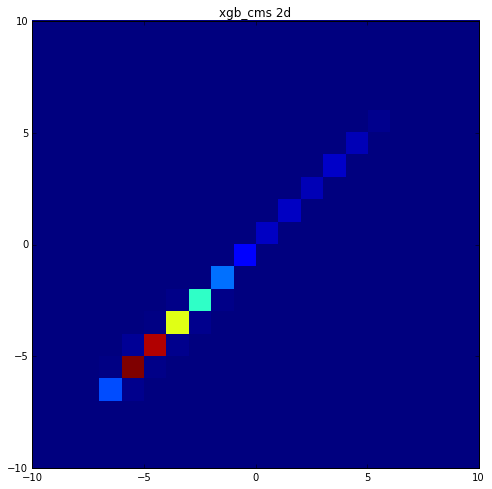

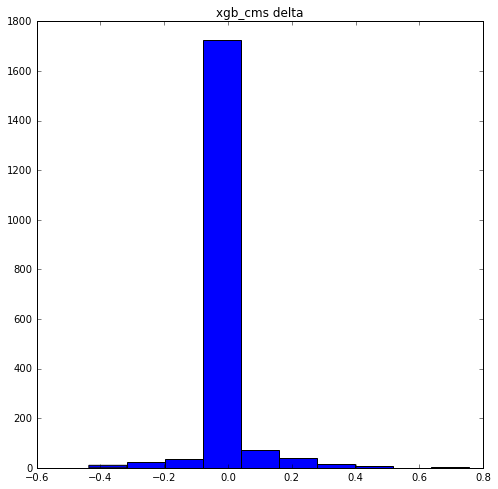

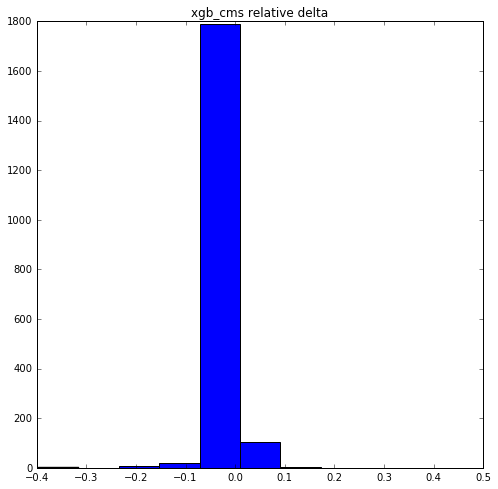

In [9]:
consistency(biased_out, data.preid_bdtout2, 'xgb_cms')

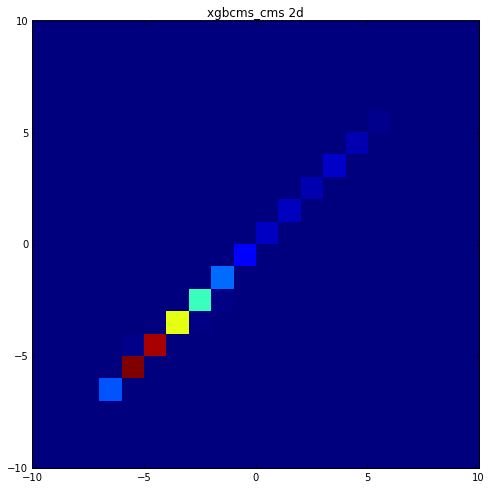

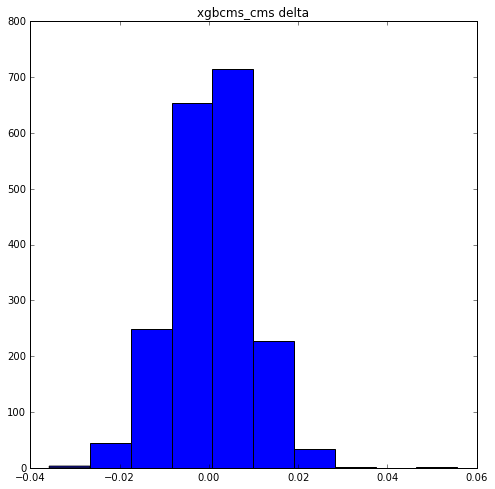

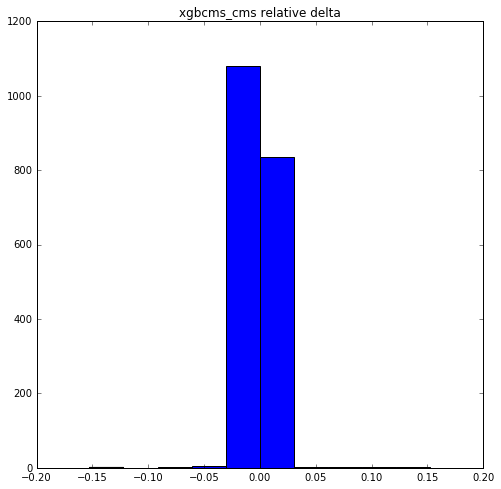

In [10]:
consistency(cmssw_biased_out, data.preid_bdtout2, 'xgbcms_cms')

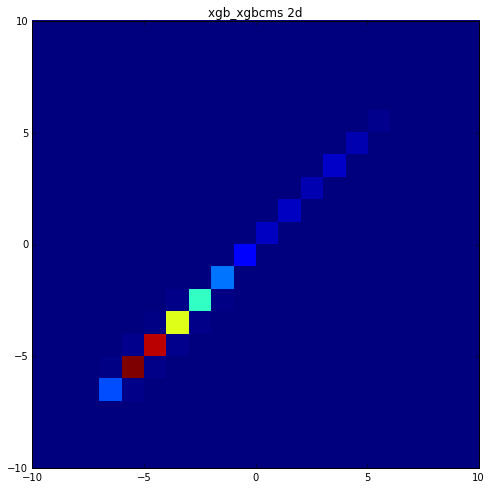

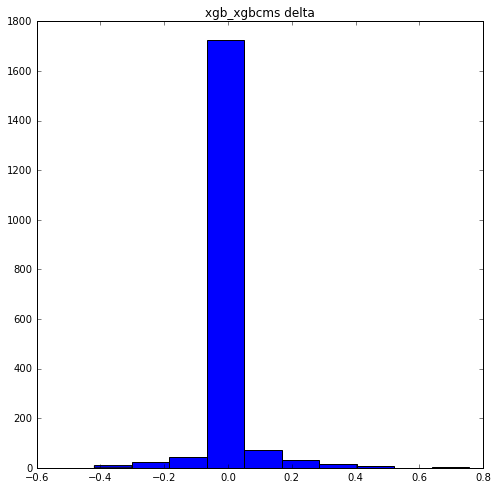

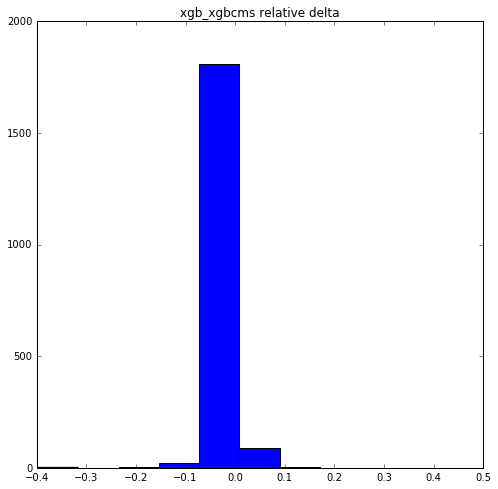

In [11]:
consistency(biased_out, cmssw_biased_out, 'xgb_xgbcms')

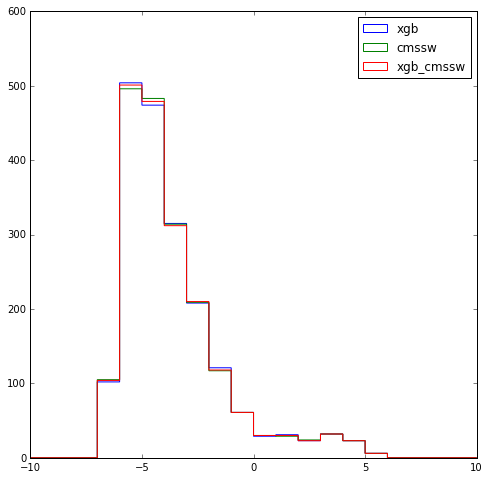

In [12]:
plt.figure(figsize=[8,8])
plt.hist(biased_out, label='xgb', range=[-10, 10], bins=20, histtype='step')
plt.hist(data.preid_bdtout2, label='cmssw', range=[-10, 10], bins=20, histtype='step')
plt.hist(cmssw_biased_out, label='xgb_cmssw', range=[-10, 10], bins=20, histtype='step')
plt.legend(loc='best')
plt.show()

In [13]:
import itertools
import scipy

In [14]:
for im, ic in itertools.izip_longest(biased_features, cmssw_feats, fillvalue='--'):
    corr, _ = scipy.stats.pearsonr(data[im], data[ic])
    print im, ' - ', ic, corr

trk_pt  -  preid_trk_pt 1.0
trk_eta  -  preid_trk_eta 1.0
trk_phi  -  preid_trk_phi 1.0
trk_p  -  preid_trk_p 1.0
trk_nhits  -  preid_trk_nhits 0.999999975729689
trk_high_purity  -  preid_trk_high_quality nan
trk_chi2red  -  preid_trk_chi2red 1.0
rho  -  preid_rho 1.0
ktf_ecal_cluster_e  -  preid_ktf_ecal_cluster_e 1.0
ktf_ecal_cluster_deta  -  preid_ktf_ecal_cluster_deta 1.0
ktf_ecal_cluster_dphi  -  preid_ktf_ecal_cluster_dphi -0.03857561664564001
ktf_ecal_cluster_e3x3  -  preid_ktf_ecal_cluster_e3x3 1.0
ktf_ecal_cluster_e5x5  -  preid_ktf_ecal_cluster_e5x5 1.0
ktf_ecal_cluster_covEtaEta  -  preid_ktf_ecal_cluster_covEtaEta 1.0
ktf_ecal_cluster_covEtaPhi  -  preid_ktf_ecal_cluster_covEtaPhi 1.0
ktf_ecal_cluster_covPhiPhi  -  preid_ktf_ecal_cluster_covPhiPhi 1.0
ktf_ecal_cluster_r9  -  preid_ktf_ecal_cluster_r9 1.0
ktf_ecal_cluster_circularity_  -  preid_ktf_ecal_cluster_circularity 1.0
ktf_hcal_cluster_e  -  preid_ktf_hcal_cluster_e 1.0
ktf_hcal_cluster_deta  -  preid_ktf_hcal_cluste

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scipy/1.1.0/lib/python2.7/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


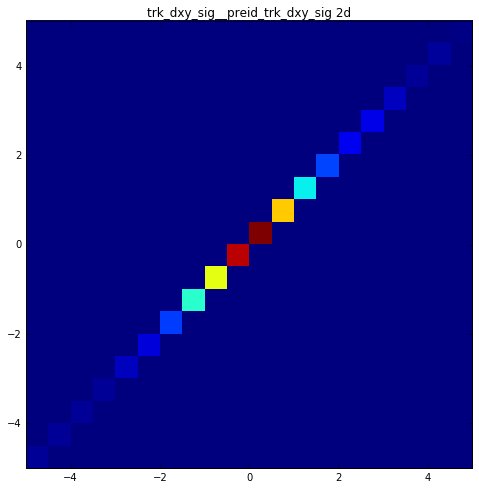

In [17]:
consistency(data['trk_dxy_sig'], data['preid_trk_dxy_sig'], '%s__%s' % (im, ic), True, [[-5,5],[-5,5]])

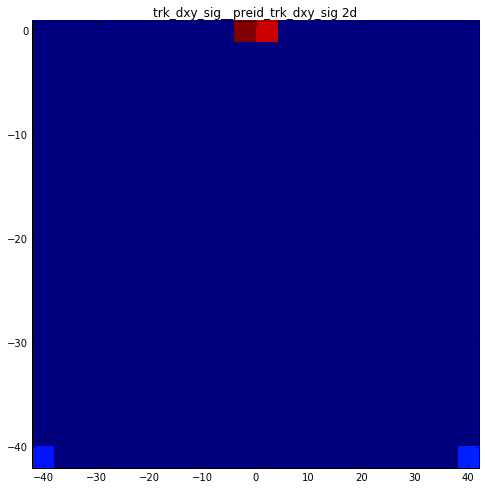

In [20]:
consistency(data.ktf_ecal_cluster_dphi, data.preid_ktf_ecal_cluster_dphi, '%s__%s' % (im, ic), True, None)

In [ ]:
aa/bb

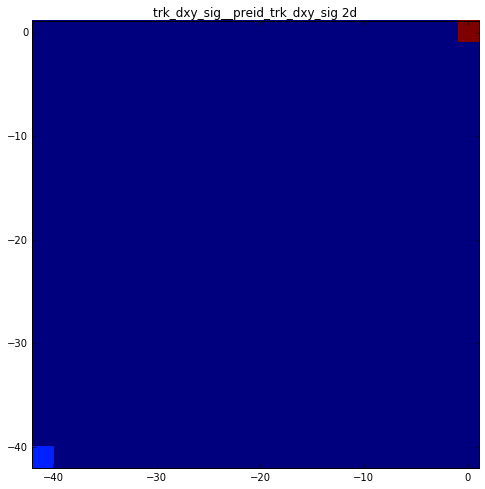

In [21]:
consistency(data['ktf_ecal_cluster_deta'], data['preid_ktf_ecal_cluster_deta'], '%s__%s' % (im, ic), True, None) #[[-1,1],[-1,1]])

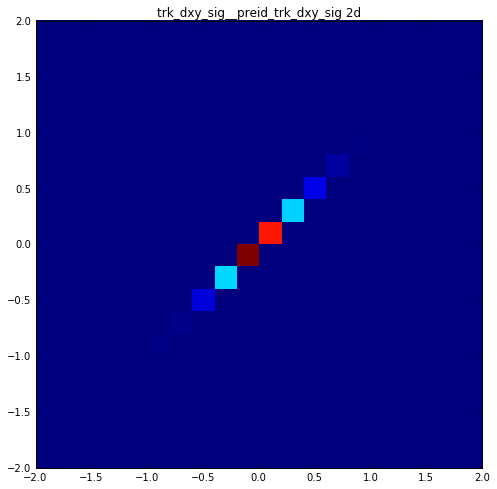

In [23]:
consistency(data['ktf_ecal_cluster_dphi'], data['preid_ktf_ecal_cluster_dphi'], '%s__%s' % (im, ic), True, [[-2,2],[-2,2]])

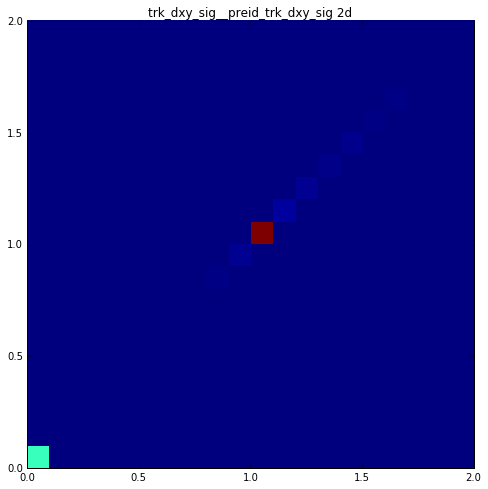

In [24]:
consistency(data['ktf_ecal_cluster_r9'], data['preid_ktf_ecal_cluster_r9'], '%s__%s' % (im, ic), True, [[0,2],[0,2]])


ktf_hcal_cluster_deta  -  preid_ktf_hcal_cluster_deta 0.9437973
ktf_hcal_cluster_dphi  -  preid_ktf_hcal_cluster_dphi 0.03227410523313402

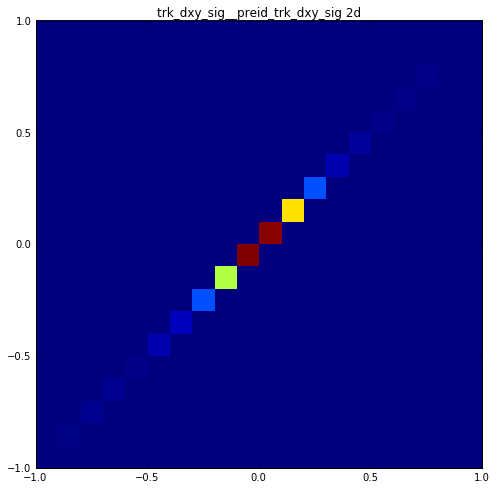

In [25]:
consistency(data['ktf_hcal_cluster_deta'], data['preid_ktf_hcal_cluster_deta'], '%s__%s' % (im, ic), True, [[-1,1],[-1,1]])

In [26]:
(data.preid_ktf_ecal_cluster_deta[data.ktf_ecal_cluster_deta < -40] == -1).all()


True

In [27]:
mask = (data.ktf_ecal_cluster_deta > -40)

In [28]:
((data.ktf_ecal_cluster_e[mask] - data.preid_ktf_ecal_cluster_e[mask])).max()


41.594242

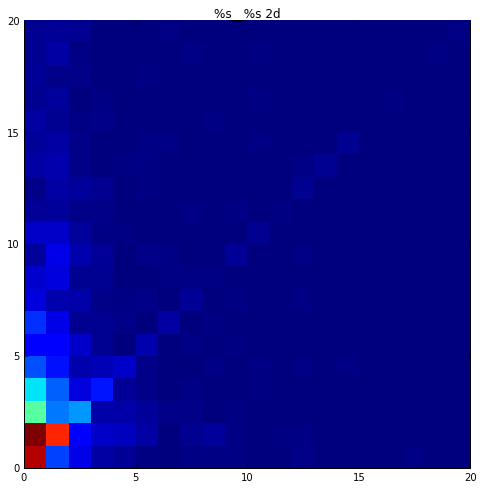

In [29]:
consistency(data['ktf_ecal_cluster_e'][mask], data['preid_ktf_ecal_cluster_e'][mask], '%s__%s', True, [[0,20],[0,20]])

In [30]:
mask2 = np.abs(data['ktf_ecal_cluster_e'][mask] - data['preid_ktf_ecal_cluster_e'][mask]) > 0.2

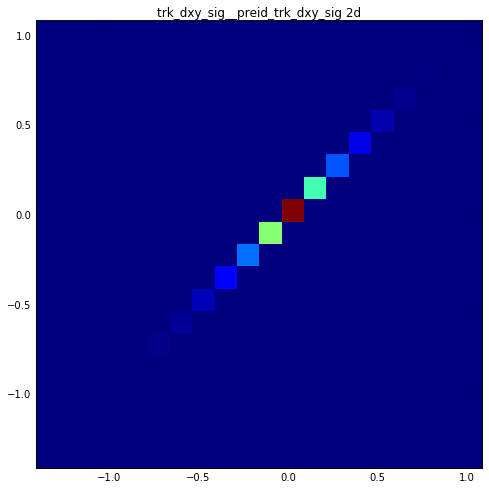

In [31]:
consistency(data['ktf_ecal_cluster_deta'][mask][mask2], data['preid_ktf_ecal_cluster_deta'][mask][mask2], '%s__%s' % (im, ic), True, None) #[[-1,1],[-1,1]])

In [32]:
np.abs(data['ktf_ecal_cluster_deta'][mask][mask2] - data['preid_ktf_ecal_cluster_deta'][mask][mask2]).max()

3.8789585e-07

In [33]:
mask2 = np.abs(data['ktf_ecal_cluster_e'] - data['preid_ktf_ecal_cluster_e']) > 0.2

In [34]:
fmask = (mask & mask2)

In [35]:
np.abs(data['ktf_ecal_cluster_e'][fmask] - data['preid_ktf_ecal_cluster_e'][fmask]).min()

0.2002995

In [37]:
data[['run','lumi','evt']][fmask].to_csv('pick_electrons.list', header=False, index=False)

In [4]:
import uproot

In [5]:
infile = uproot.open('/afs/cern.ch/work/m/mverzett/RK10_2/src/LowPtElectrons/LowPtElectrons/run/full_test.root')
raw = pd.DataFrame(infile['features/tree'].arrays(['run','lumi','evt','ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e','ktf_ecal_cluster_deta', 'preid_ktf_ecal_cluster_deta']))

In [6]:
raw[raw.evt == 447755850][['ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e']]

,ktf_ecal_cluster_e,preid_ktf_ecal_cluster_e
0,-1.000000,-1.000000
1,1.102445,13.437003
2,1.148261,1.451249
3,1.955788,8.763627
4,0.655272,5.511606
5,1.355592,2.113458
6,1.180530,1.180530
7,0.696872,7.216166


In [44]:
infile2 = uproot.open('/afs/cern.ch/work/m/mverzett/RK10_2/src/LowPtElectrons/LowPtElectrons/run/track_features.root')
raw2 = pd.DataFrame(infile2['features/tree'].arrays(['run','lumi','evt','ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e','ktf_ecal_cluster_deta', 'preid_ktf_ecal_cluster_deta']))

In [45]:
raw2[raw2.evt == 447755850][['ktf_ecal_cluster_e','preid_ktf_ecal_cluster_e']]

,ktf_ecal_cluster_e,preid_ktf_ecal_cluster_e
0,-1.000000,-1.000000
1,1.102445,13.437003
2,1.148261,1.451249
3,1.955788,8.763627
4,0.655272,5.511606
5,1.355592,2.113458
6,1.180530,1.180530
7,0.696872,7.216166


In [15]:
for im, ic in itertools.izip_longest(biased_features, cmssw_feats, fillvalue='--'):
    corr, _ = scipy.stats.pearsonr(data[im], data[ic])
    print im, ' - ', ic, corr

trk_pt  -  preid_trk_pt 1.0
trk_eta  -  preid_trk_eta 1.0
trk_phi  -  preid_trk_phi 1.0
trk_p  -  preid_trk_p 1.0
trk_nhits  -  preid_trk_nhits 0.999999975729689
trk_high_purity  -  preid_trk_high_quality nan
trk_chi2red  -  preid_trk_chi2red 1.0
rho  -  preid_rho 1.0
ktf_ecal_cluster_e  -  preid_ktf_ecal_cluster_e 0.17888232
ktf_ecal_cluster_deta  -  preid_ktf_ecal_cluster_deta 0.8257967
ktf_ecal_cluster_dphi  -  preid_ktf_ecal_cluster_dphi -0.025892271341906425
ktf_ecal_cluster_e3x3  -  preid_ktf_ecal_cluster_e3x3 1.0
ktf_ecal_cluster_e5x5  -  preid_ktf_ecal_cluster_e5x5 1.0
ktf_ecal_cluster_covEtaEta  -  preid_ktf_ecal_cluster_covEtaEta 0.9994851
ktf_ecal_cluster_covEtaPhi  -  preid_ktf_ecal_cluster_covEtaPhi 0.99948496
ktf_ecal_cluster_covPhiPhi  -  preid_ktf_ecal_cluster_covPhiPhi 0.99948514
ktf_ecal_cluster_r9  -  preid_ktf_ecal_cluster_r9 0.9383253
ktf_ecal_cluster_circularity_  -  preid_ktf_ecal_cluster_circularity 1.0
ktf_hcal_cluster_e  -  preid_ktf_hcal_cluster_e nan
ktf_hca

In [17]:
bad = data['trk_nhits'] != data['preid_trk_nhits']
data['trk_nhits'][bad], data['preid_trk_nhits'][bad]

(Series([], Name: trk_nhits, dtype: int32),
 Series([], Name: preid_trk_nhits, dtype: float32))

In [18]:
bad.any()

False